Package Import

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.utils import Progbar
import time
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.compat.v1 import logging
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.callbacks import LambdaCallback

logging.set_verbosity(logging.ERROR)
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

Get training data

(-2.0, 2.0)

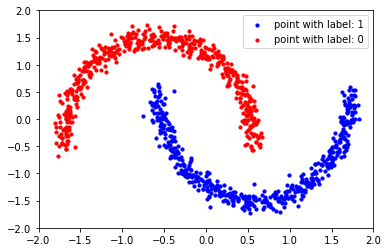

In [91]:
n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
# turn into having zero mean and one variance
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2,2], [-2,2]
y_label = y.astype(np.bool)
X_train, Y_train = X_data[...,0], X_data[...,1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color='blue')
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color='red')
plt.legend(['point with label: 1', 'point with label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)

Normalizing Flow Construction

In [92]:
base_distribution = tfd.Normal(loc=0.,scale=1.0)
def make_masked_autoregressive_flow(hidden_units=[16,16], activation='relu'):
    # two hidden layers, each with 16 untis, and activation function as relu
    # made is a neural Network which output the 'shift_and_log_scale_fn', a integral part of MAF
    made = tfb.AutoregressiveNetwork(
            params=2, event_shape=[2], hidden_units=hidden_units, activation=activation)
    # MAF, a special type of normalizing flow bijector which takes input a made network that computes shift function as well as the log-scaled scale function
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

num_bijector = 6
bijectors = []
for i in range(num_bijector):
    make_auto_i = make_masked_autoregressive_flow(hidden_units=[256,256], activation='relu')
    bijectors.append(make_auto_i)
    bijectors.append(tfb.Permute([1,0]))
    
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

trainable_distribution = tfd.TransformedDistribution(distribution = base_distribution,
                                                     bijector=flow_bijector,
                                                     event_shape=[2])

Plot and Training Function

In [93]:
def make_samples():
    x = base_distribution.sample((1000,2))
    samples = [x]
    names = [base_distribution.name]
    for bijector in reversed(trainable_distribution.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

def plot_contour_prob(dist, rows=1, title=[''], scale_fig=4):
    cols = int(len(dist)/rows)
    xx = np.linspace(-5.0, 5.0, 100)
    yy = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(xx, yy)
    
    fig, ax = plt.subplots(rows, cols, figsize=(scale_fig * cols, scale_fig * rows))
    fig.tight_layout(pad=4.5)
    
    i=0
    for r in range(rows):
        for c in range(cols):
            #dstack takes two array with same shape, np.dstack((X,Y))[...,0] = X    
            Z = dist[i].prob(np.dstack((X, Y)))
            if len(dist) == 1:
                axi = ax
            elif rows == 1:
                axi = ax[c]
            else: 
                axi = ax[r, c]
            
            # Plot contour
            p = axi.contourf(X, Y, Z)
            
            # Add a colorbar
            divider = make_axes_locatable(axi)
            cax = divider.append_axes("right", size='5%', pad=0.1)
            cbar = fig.colorbar(p, cax=cax)
            
            # Set title and labels
            axi.set_title('Filled Contours Plot: ' + str(title[i]))
            axi.set_xlabel('x')
            axi.set_ylabel('y')
            
            i += 1

def _plot(results, rows=1, legend=False):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[...,1].numpy()
            # when there are only one rows, 'arr' has shape [cols]
            if rows == 1:
                p = arr[c]
            # when there are multiple rows, 'arr' has shape [cols, rows]
            else:
                p = arr[r,c]
            p.scatter(X, Y, s=10, color='red')
            p.set_xlim([-5,5])
            p.set_ylim([-5,5])
            p.set_title(names[i])

            i += 1
            
def visualize_training_data(samples):
    f, arr = plt.subplots(1, 2, figsize=(15,6))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]
    
    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[...,1].numpy()
        arr[i].scatter(X, Y, s=10, color='red')
        arr[i].set_xlim([-2,2])
        arr[i].set_ylim([-2,2])
        arr[i].set_title(names[i])
        
def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x1 = Input(shape=(2,), dtype=tf.float32)
    log_prob1 = trainable_distribution.log_prob(x1)
    model = Model(inputs=x1, outputs=log_prob1)

    model.compile(optimizer=tf.optimizers.Adam(),
                  loss = lambda _, log_prob1: -log_prob1)

    ns = X_data.shape[0]
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )
    # actual line to get things trained
    history = model.fit(x=X_data, 
                        y=np.zeros((ns,0), dtype=np.float32),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback])
    return history

Pre-training samples from the trainbale distribution

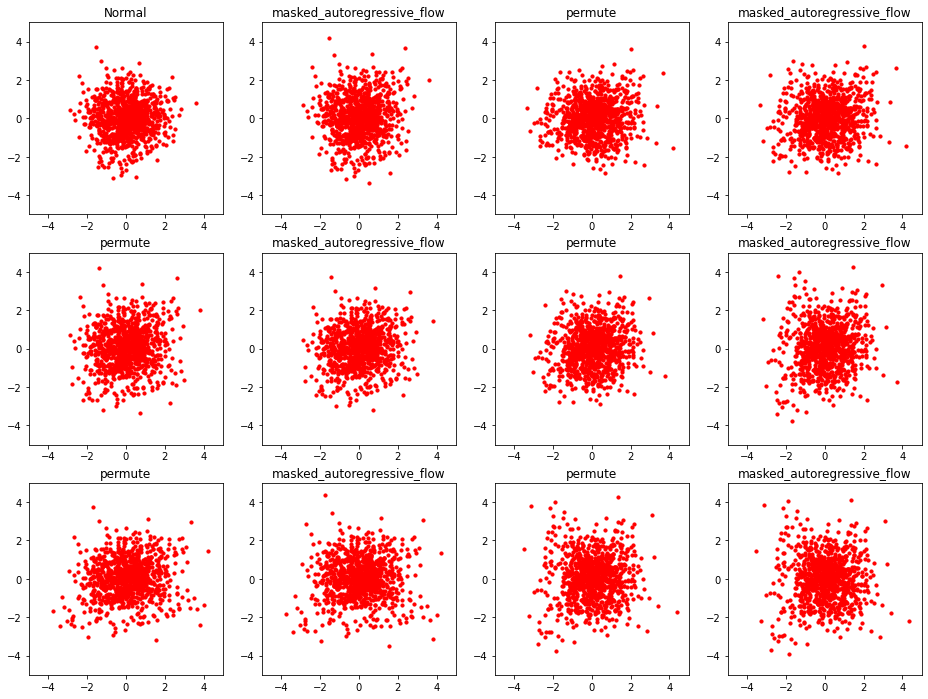

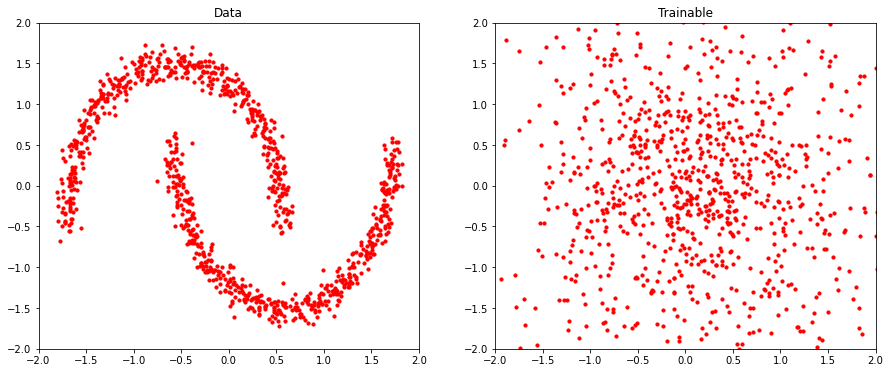

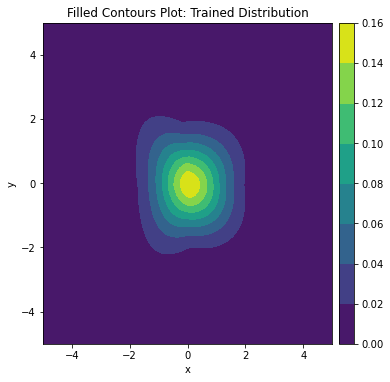

In [94]:
names, samples = make_samples()
_plot(samples, rows=3)
visualize_training_data(samples)
plot_contour_prob([trainable_distribution], rows=1, title=['Trained Distribution'], scale_fig=6)

Training Loop

In [95]:
history = train_dist_routine(trainable_distribution, n_epochs=600, n_disp=50)


 Epoch 1/600 
	 loss: 2.9359, val_loss: 2.6123

 Epoch 51/600 
	 loss: 2.1733, val_loss: 2.1725

 Epoch 101/600 
	 loss: 1.7366, val_loss: 1.7446

 Epoch 151/600 
	 loss: 1.9457, val_loss: 2.1009

 Epoch 201/600 
	 loss: 1.6400, val_loss: 1.7343

 Epoch 251/600 
	 loss: 1.6024, val_loss: 1.5938

 Epoch 301/600 
	 loss: 1.3675, val_loss: 1.3845

 Epoch 351/600 
	 loss: 1.3987, val_loss: 1.4214

 Epoch 401/600 
	 loss: 1.2905, val_loss: 1.3824

 Epoch 451/600 
	 loss: 1.2661, val_loss: 1.3529

 Epoch 501/600 
	 loss: 1.2624, val_loss: 1.3429

 Epoch 551/600 
	 loss: 1.2354, val_loss: 1.2984


Training result:

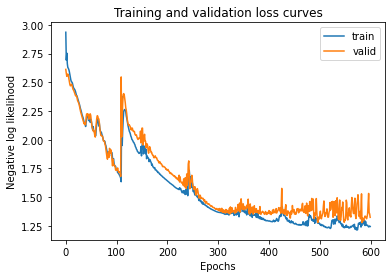

In [96]:
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

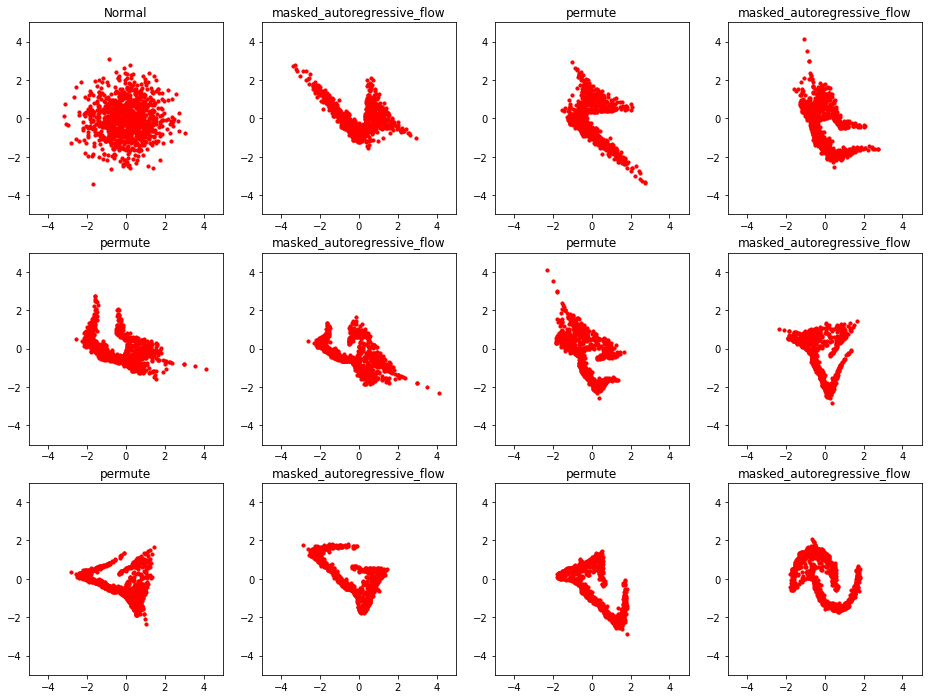

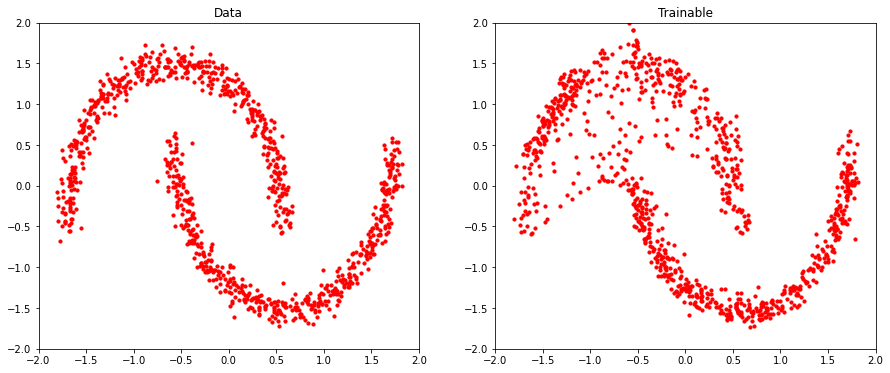

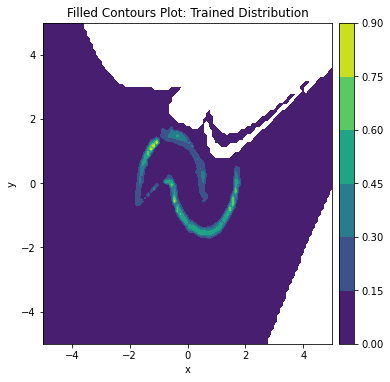

In [97]:
names, samples = make_samples()
_plot(samples, rows=3)
visualize_training_data(samples)
plot_contour_prob([trainable_distribution], rows=1, title=['Trained Distribution'], scale_fig=6)